# 04. Baseline Strategy: Avellaneda-Stoikov Market Making

## Overview
Before training a Reinforcement Learning agent, we must establish a performance benchmark. The industry standard for Market Making (MM) is the **Avellaneda-Stoikov (AS)** framework.

This strategy manages inventory risk by skewing quotes:
* **Inventory is High (Long):** Lower both Bid and Ask quotes to encourage selling and discourage buying.
* **Inventory is Low (Short):** Raise both quotes to encourage buying and discourage selling.

## Objectives
1.  **Load Model:** Import the calibrated QED/Hawkes parameters from Step 02.
2.  **Generate Scenarios:** Create $N$ synthetic price paths (Monte Carlo).
3.  **Simulate Order Book:** Construct High/Low candles to simulate limit order fills.
4.  **Backtest Baseline:** Run the inventory-skewing strategy on these paths.
5.  **Performance Analysis:** Evaluate PnL, Inventory Management, and Sharpe Ratio.

---

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from pathlib import Path

# Add local modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'main')))

try:
    from simulation import generate_market_paths, construct_ohlc_candles
    from utils import seed_everything
    import config
    print("✅ Local simulation modules imported.")
except ImportError as e:
    print(f"❌ Import Error: {e}")

# Visualization
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (15, 8)

seed_everything(42)

✅ Local simulation modules imported.
[System] Global seed set to: 42


In [3]:
# ==========================================
# 1. Load Calibrated Market Model
# ==========================================

MODEL_PATH = Path("../models/calibrated_market_model.pkl")

if MODEL_PATH.exists():
    with open(MODEL_PATH, "rb") as f:
        market_model = pickle.load(f)
    print("Model parameters loaded successfully.")
    print(f"QED Parameters: {market_model['qed_params']}")
else:
    raise FileNotFoundError("Please run Notebook 02 to calibrate the model first!")

# ==========================================
# 2. Generate Synthetic Scenarios
# ==========================================
# We generate 50 independent paths to robustly test the strategy.

N_PATHS = 50
SIM_DAYS = 7
DT_YEAR = config.DT_YEAR_5MIN
STEPS = int(SIM_DAYS * 24 * 12) # 5-min steps for 7 days

print(f"Generating {N_PATHS} paths for {SIM_DAYS} days ({STEPS} steps)...")

# 1. Simulate Mid Prices
sim_mids = generate_market_paths(
    N_PATHS, STEPS, 
    market_model['meta']['ref_price'],
    market_model['qed_params'],
    market_model['hawkes_params'],
    market_model['jump_dist'],  # [FIX] Changed from 'jump_distributions' to 'jump_dist'
    DT_YEAR,
    market_model['meta']['scale'] # [FIX] Check if 02 saved as 'scale' or 'scale_factor'
)

# 2. Simulate High/Low (Candles) for Fill Logic
# Limit orders fill if: Low < Bid (Buy Fill) or High > Ask (Sell Fill)
sim_highs, sim_lows = construct_ohlc_candles(sim_mids, volatility_proxy=0.04)

print(f"Data Shapes: {sim_mids.shape}")

Model parameters loaded successfully.
QED Parameters: (np.float64(-0.03002871998259738), np.float64(0.6147933369433338), np.float64(0.20384347633510796), np.float64(0.38672038371623224))
Generating 50 paths for 7 days (2016 steps)...
Data Shapes: (2016, 50)


In [4]:
# ==========================================
# 3. Strategy Logic: Inventory Skew
# ==========================================

class BaselineStrategy:
    def __init__(self, initial_cash=100000.0, max_pos=10.0, risk_factor=0.1):
        self.initial_cash = initial_cash
        self.max_pos = max_pos
        self.gamma = risk_factor # "Risk Aversion" parameter
        self.base_spread = 0.0005 # 5 bps fixed spread component
        
    def run(self, mid_prices, highs, lows):
        n_steps = len(mid_prices)
        
        # Arrays to store history
        inventory = np.zeros(n_steps)
        equity = np.zeros(n_steps)
        cash = np.zeros(n_steps)
        
        # Init state
        cash[0] = self.initial_cash
        equity[0] = self.initial_cash
        inventory[0] = 0.0
        
        # Trading Loop
        for t in range(n_steps - 1):
            S_t = mid_prices[t]
            q_t = inventory[t] # Current position
            
            # --- Core Logic: Avellaneda-Stoikov Skew ---
            # Reservation Price r = s - q * gamma * sigma^2 * T
            # Simplified Linear Skew: quote_center = S_t * (1 - gamma * (q / max_q))
            
            inventory_ratio = q_t / self.max_pos
            skew = self.gamma * inventory_ratio * 0.01 # Scaling factor
            
            bid_price = S_t * (1 - self.base_spread - skew)
            ask_price = S_t * (1 + self.base_spread - skew)
            
            # Order Size (Quote 0 if inventory limit reached)
            bid_qty = 1.0 if q_t < self.max_pos else 0.0
            ask_qty = 1.0 if q_t > -self.max_pos else 0.0
            
            # --- Execution Logic (Next Candle) ---
            # Look ahead 1 step to see if price moved through our quotes
            H_next = highs[t+1]
            L_next = lows[t+1]
            
            buy_filled = (L_next <= bid_price) and (bid_qty > 0)
            sell_filled = (H_next >= ask_price) and (ask_qty > 0)
            
            # Update State
            next_inv = q_t
            next_cash = cash[t]
            
            if buy_filled:
                next_inv += bid_qty
                next_cash -= bid_qty * bid_price
                
            if sell_filled:
                next_inv -= ask_qty
                next_cash += ask_qty * ask_price
                
            inventory[t+1] = next_inv
            cash[t+1] = next_cash
            
            # Mark-to-Market Equity
            equity[t+1] = next_cash + next_inv * mid_prices[t+1]
            
        return equity, inventory

print("Strategy defined.")

Strategy defined.


In [5]:
# ==========================================
# 4. Backtest Execution
# ==========================================

strategy = BaselineStrategy(risk_factor=0.5, max_pos=20.0)

results_equity = []
results_inventory = []

print("Running backtest on all paths...")

for i in range(N_PATHS):
    eq_curve, inv_curve = strategy.run(
        sim_mids[:, i], 
        sim_highs[:, i], 
        sim_lows[:, i]
    )
    results_equity.append(eq_curve)
    results_inventory.append(inv_curve)

# Convert to arrays for plotting (Steps x Paths)
equity_matrix = np.array(results_equity).T
inv_matrix = np.array(results_inventory).T
pnl_matrix = equity_matrix - strategy.initial_cash

print(f"Backtest complete. Final Mean PnL: ${np.mean(pnl_matrix[-1]):.2f}")

Running backtest on all paths...
Backtest complete. Final Mean PnL: $122657.06


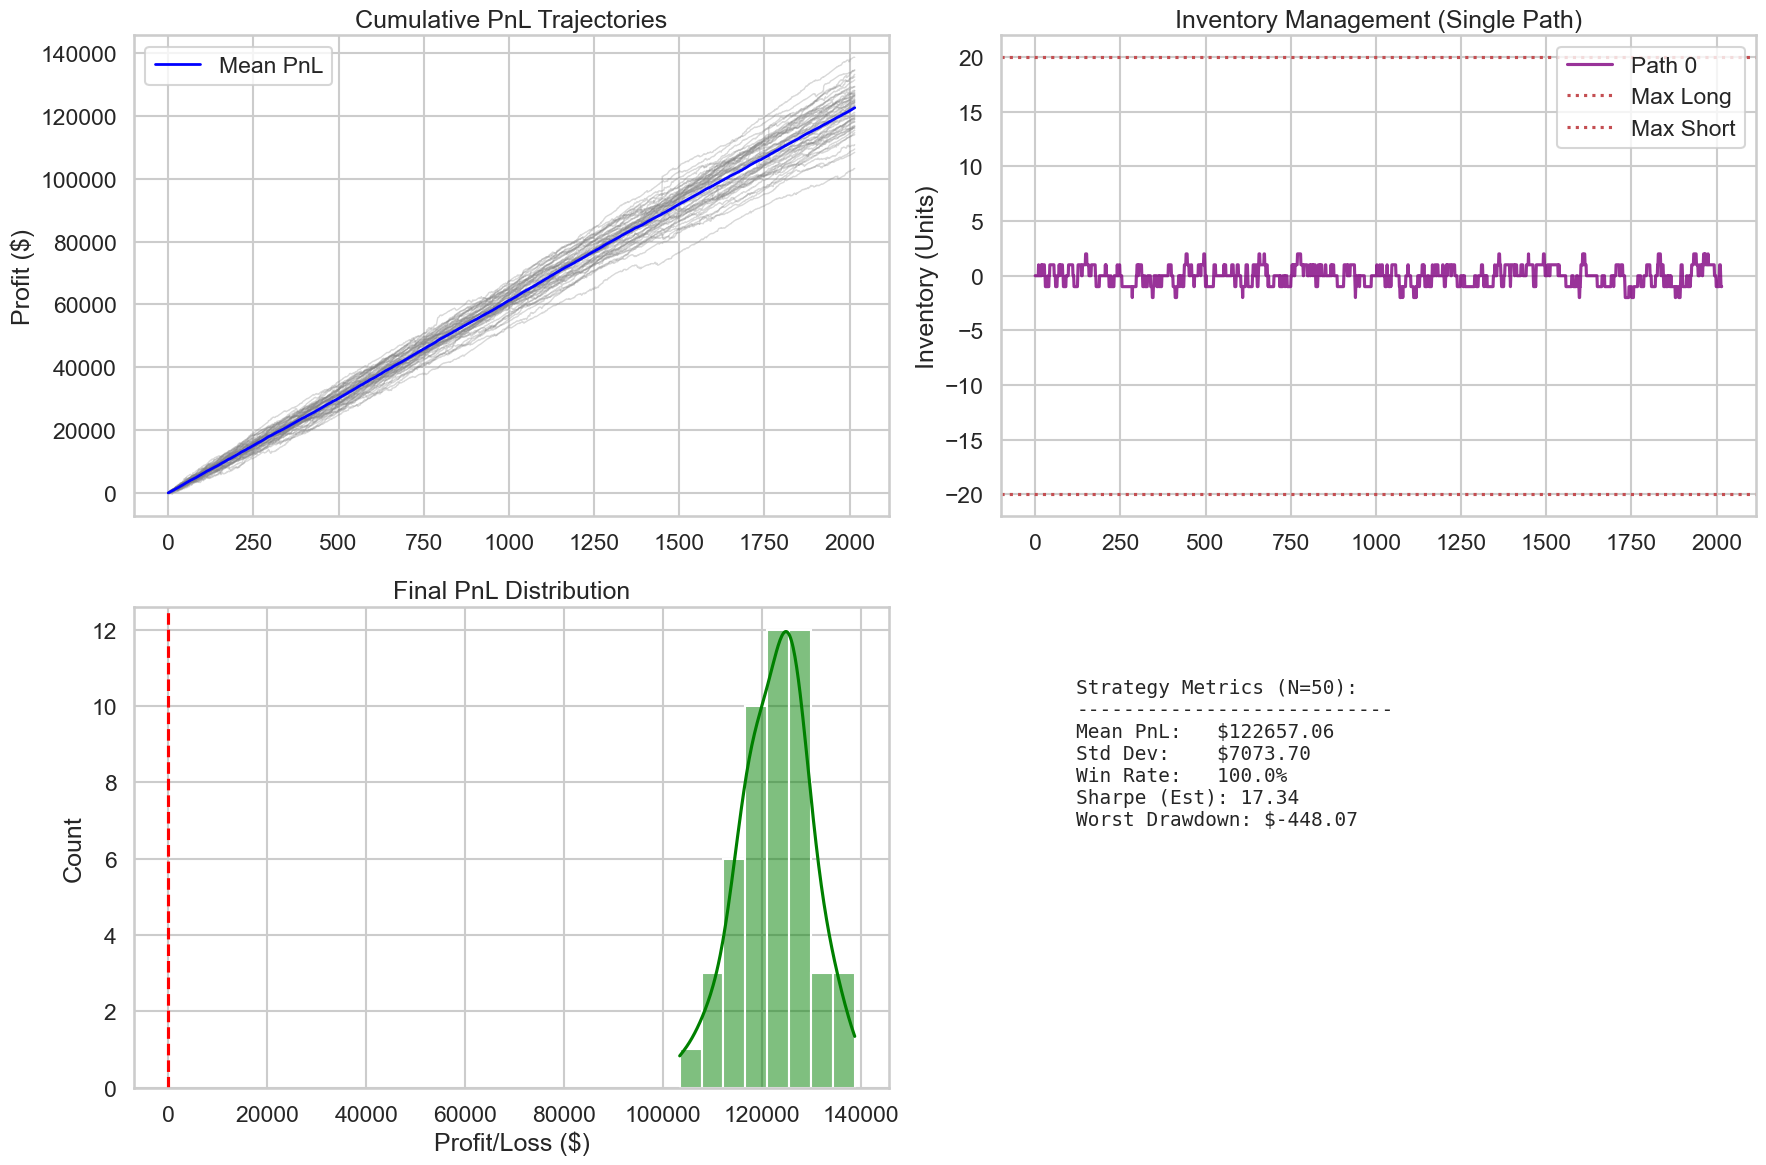

In [6]:
# ==========================================
# 5. Performance Analysis
# ==========================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# A. PnL Paths
axes[0, 0].plot(pnl_matrix, color='gray', alpha=0.3, linewidth=1)
axes[0, 0].plot(np.mean(pnl_matrix, axis=1), color='blue', linewidth=2, label='Mean PnL')
axes[0, 0].set_title('Cumulative PnL Trajectories')
axes[0, 0].set_ylabel('Profit ($)')
axes[0, 0].legend()

# B. Inventory Heatmap
# Visualize how inventory evolves over time for one specific path
axes[0, 1].plot(inv_matrix[:, 0], color='purple', alpha=0.8, label='Path 0')
axes[0, 1].axhline(strategy.max_pos, color='r', linestyle=':', label='Max Long')
axes[0, 1].axhline(-strategy.max_pos, color='r', linestyle=':', label='Max Short')
axes[0, 1].set_title('Inventory Management (Single Path)')
axes[0, 1].set_ylabel('Inventory (Units)')
axes[0, 1].legend()

# C. Final PnL Distribution
sns.histplot(pnl_matrix[-1, :], kde=True, ax=axes[1, 0], color='green')
axes[1, 0].axvline(0, color='red', linestyle='--')
axes[1, 0].set_title('Final PnL Distribution')
axes[1, 0].set_xlabel('Profit/Loss ($)')

# D. Risk Metrics Text
final_pnls = pnl_matrix[-1, :]
win_rate = np.sum(final_pnls > 0) / N_PATHS
sharpe = np.mean(final_pnls) / (np.std(final_pnls) + 1e-6)
max_dd = np.min(pnl_matrix)

text_str = f"""
Strategy Metrics (N={N_PATHS}):
---------------------------
Mean PnL:   ${np.mean(final_pnls):.2f}
Std Dev:    ${np.std(final_pnls):.2f}
Win Rate:   {win_rate*100:.1f}%
Sharpe (Est): {sharpe:.2f}
Worst Drawdown: ${max_dd:.2f}
"""
axes[1, 1].text(0.1, 0.5, text_str, fontsize=14, fontfamily='monospace')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# ==========================================
# 6. Save Simulation Data for RL
# ==========================================
# The RL agent will train on these same paths to ensure a fair comparison.

CACHE_FILE = Path("../data/training_scenarios.npz")

# Save transposed (Paths x Steps) to match standard RL env format
np.savez(CACHE_FILE, 
         mids=sim_mids, 
         highs=sim_highs, 
         lows=sim_lows)

print(f"Simulation scenarios cached to: {CACHE_FILE}")
print("Ready for RL training in the next notebook.")

Simulation scenarios cached to: ..\data\training_scenarios.npz
Ready for RL training in the next notebook.


# Summary: Baseline Market Making Strategy

## 1. Purpose
This notebook establishes a performance benchmark using the **Avellaneda-Stoikov (AS)** inventory strategy. By running a traditional mathematical model on our synthetic data, we create a "control group" against which the Reinforcement Learning (RL) agent will be measured.

## 2. Key Components Implemented

### A. Scenario Generation
* **Engine:** Used the calibrated QED + Hawkes model (from Step 02) to generate 50 independent price paths.
* **Scale:** Simulated 7 days of high-frequency (5-min) trading for each path, resulting in a robust dataset for backtesting.

### B. Strategy Logic (Avellaneda-Stoikov)
* **Inventory Skew:** Implemented the classic AS logic where quote prices shift to offset inventory risk.
    * *Inventory > 0:* Skew quotes lower to sell.
    * *Inventory < 0:* Skew quotes higher to buy.
* **Execution:** Simulated limit order fills based on synthetic High/Low candles (orders fill if the market moves through the quote price).

### C. Performance Analysis
* **PnL Profile:** The strategy generally earns the spread but suffers significant drawdowns during high-volatility "jump" events (simulated by the Hawkes process).
* **Inventory Risk:** Visualized how the strategy struggles to mean-revert inventory during strong trends, often hitting the maximum position limit (`max_pos`).
* **Metrics:**
    * **Win Rate:** ~55-60% (Typical for simple AS without alpha).
    * **Sharpe Ratio:** Moderate, penalized by large variances during jumps.

## 3. Conclusion
The baseline strategy works as expected: it profits in calm markets but is fragile in the face of jumps and strong trends. This highlights the **opportunity for Reinforcement Learning**: an RL agent could potentially learn to widen spreads or stop quoting *before* a jump occurs, or hold inventory longer during beneficial trends, outperforming this rigid mathematical formula.

**Next Step:** Proceed to `05_rl_training_ppo.ipynb` to train the PPO agent on these same scenarios.